In [1]:
import pandas as pd
import numpy as np
import math

# Finance
import mplfinance as mpf
import ta
import yfinance as yf

import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from torch.optim import Adam

import matplotlib.pyplot as plt
import shap



# System
from dotenv import load_dotenv
import os
from pathlib import Path
import requests
import sys
import time

sys.path.append('../') # Change the python path at runtime
from src.utils import path as path_yq


/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
cur_dir = Path.cwd()

POLYGON_API_KEY = os.environ.get("POLYGON_API_KEY")

# Fetch Tick Data
- Add feature to pull from data instead of fetching

## Polygon API

In [4]:
# TODO: Scale this up to n years
ticker = "NVDA"
max_limit = 50000
start_date = "2000-01-01"
end_date = "2024-12-31"

api_url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit={max_limit}&apiKey={POLYGON_API_KEY}"



In [ ]:
str = "N" # Reset
str = input("Confirm?")

if str == "Y":
    resp = requests.get(api_url)
    print(f"Request made.")

In [ ]:
resp

In [ ]:
cols = ["Date", "Open", "High", "Low", "Close", "Volume", "VWAP", "Transactions"]
if resp.status_code == 200:
    dict_list = resp.json().get('results')
    df = pd.DataFrame(dict_list)

    column_map = {
        't': 'Timestamp',
        'o': 'Open',
        'h': 'High',
        'l': 'Low',
        'c': 'Close', 
        'n': 'Transactions', # Number of trades (market activity)
        'v': 'Volume', # Number of shares traded (intensity of the activity)
        'vw': 'VWAP'
    }

    df.rename(columns=column_map, inplace=True)

    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df['Date'] = df['Datetime'].dt.normalize() # Remove the time and return date object

    df = df[cols]
    df.set_index(keys="Date", inplace=True)
else:
    print(f"Error fetching data: {resp.status_code}, {resp.text}")

In [ ]:
df

## Yfinance

In [ ]:
import seaborn as sns
historical_start_date = '2022-08-09'
# Define the ticker list
# Capitaland A17U, SUNT.SI cannot download
ticker_list = ['S51.SI']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.index = pd.to_datetime(data.index)
display(data.tail(20))
data.plot()

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [ ]:
df


## Read Data

In [5]:
root_dir = path_yq.get_root_dir(cur_dir=cur_dir)
csv_path = Path.joinpath(root_dir, "data", f"{ticker}_{start_date}_{end_date}.csv")

# Get df
try:
    df.to_csv(csv_path)
except NameError:
    print(f"df not defined, trying to fetch from csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # Convert data
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index(keys="Date", inplace=True)

df not defined, trying to fetch from csv


In [ ]:
df.tail(6)

mpf plot: https://github.com/matplotlib/mplfinance?tab=readme-ov-file

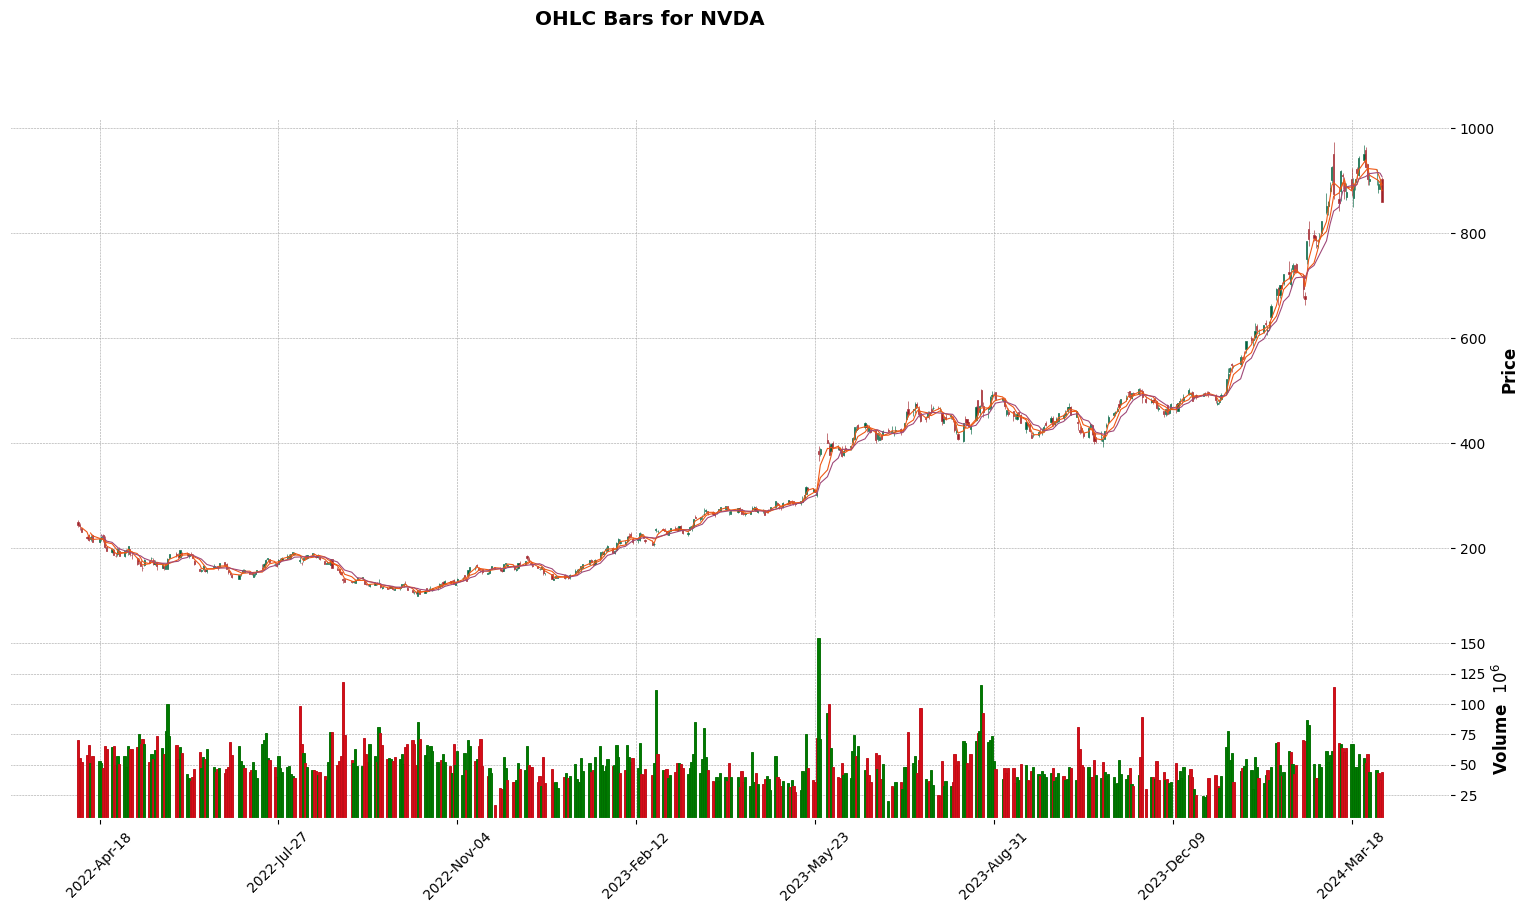

In [87]:
mpf.plot(df, type='candle', style='charles', figsize=(20, 10), title="OHLC Bars for NVDA", volume=True, show_nontrading=True, mav=(3, 6, 9))

In [ ]:
df.isna().sum()


## Read and Preprocess Bryan's Data


In [8]:
csv_path = Path.joinpath(path_yq.get_root_dir(cur_dir=cur_dir), 'data', 'capitaland.csv')
df2 = pd.read_csv(csv_path)
df2['Date'] = pd.to_datetime(df2['Date']).dt.normalize()

assert (df2.index == df2.sort_values(by='Date', ascending=True).index).all(), 'df is not sorted in ascending'
df2['Year'] = df2.Date.dt.year
df2['Month'] = df2.Date.dt.month
df2['Day'] = df2.Date.dt.day

if input('Add additional features?') == 'Y':
    # Testing additional features
    df2['BB High'], df2['BB Low']= ta.volatility.bollinger_hband(df2['A17U.SI_Close']), ta.volatility.bollinger_lband(df2['A17U.SI_Close'])

    df2['MA_50'] = df2['A17U.SI_Close'].rolling(window=50).mean()

    df2['MA_20'] = df2['A17U.SI_Close'].rolling(window=20).mean()

    df2['MA_5'] = df2['A17U.SI_Close'].rolling(window=5).mean()
df2.drop(columns='Date', inplace=True)
df2.dropna(inplace=True)
print(df2.isna().sum())

df2

A17U.SI_Open          0
A17U.SI_High          0
A17U.SI_Low           0
A17U.SI_Close         0
A17U.SI_Volume        0
A17U.SI_Dividends     0
A17U.SI_Next_Close    0
Year                  0
Month                 0
Day                   0
dtype: int64


,A17U.SI_Open,A17U.SI_High,A17U.SI_Low,A17U.SI_Close,A17U.SI_Volume,A17U.SI_Dividends,A17U.SI_Next_Close,Year,Month,Day
0,2.521650,2.538574,2.504727,2.521650,10916700,0.05740,2.513188,2021,1,4
1,2.530112,2.538574,2.504726,2.513188,10010400,0.05740,2.563959,2021,1,5
2,2.530112,2.597807,2.530112,2.563959,22244500,0.05740,2.538574,2021,1,6
3,2.572422,2.580884,2.538574,2.538574,16010000,0.05740,2.572421,2021,1,7
4,2.547036,2.572421,2.538574,2.572421,10073900,0.05740,2.572421,2021,1,8
...,...,...,...,...,...,...,...,...,...,...
813,2.800000,2.830000,2.770000,2.770000,9167500,0.07441,2.780000,2024,3,28
814,2.770000,2.790000,2.750000,2.780000,5550600,0.07441,2.760000,2024,4,1
815,2.780000,2.790000,2.750000,2.760000,11393700,0.07441,2.730000,2024,4,2
816,2.750000,2.750000,2.720000,2.730000,12905200,0.07441,2.740000,2024,4,3


# Features
- Technical indicators
- Fundamental indicators
- Date features
- Holiday indicators etc.

# Preprocessing
- Train-test split
- Scale data (only fit-transform for train, but not for test)
- Decide which to predict. Have open and predict the close for the same day? Have the close for the previous day and predict next open?

In [6]:
def create_technical_indicators(tmp: pd.DataFrame):
    df = tmp.copy(deep=True)

    # Date features
    df['Year'], df['Month'], df['Day'] = df.index.year, df.index.month, df.index.day

    # Use the close price to create the indicators
    df['BB High'], df['BB Low']= ta.volatility.bollinger_hband(df['Close']), ta.volatility.bollinger_lband(df['Close'])
    
    # Takes the past 20 data, including the current one to calculate the mean
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    df['MA_20'] = df['Close'].rolling(window=20).mean()

    df['MA_5'] = df['Close'].rolling(window=5).mean()

    df['Future Close'] = df['Close'].shift(-1)

    return df

In [34]:
df2 = create_technical_indicators(tmp=df)

In [35]:
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,,,,
2022-04-06,249.34,253.0000,240.0300,244.07,70076148.0,245.2649,988183,2022,4,6,NaN,NaN,NaN,NaN,NaN,242.08
2022-04-07,244.41,247.2200,234.7800,242.08,55799236.0,241.5490,714654,2022,4,7,NaN,NaN,NaN,NaN,NaN,231.19
2022-04-08,239.17,239.2300,230.6201,231.19,52478064.0,233.2497,671401,2022,4,8,NaN,NaN,NaN,NaN,NaN,219.17
2022-04-11,222.14,223.1994,216.6000,219.17,57483434.0,219.5560,883230,2022,4,11,NaN,NaN,NaN,NaN,NaN,215.04
2022-04-12,225.37,227.2500,212.8204,215.04,65771807.0,218.7215,926864,2022,4,12,NaN,NaN,NaN,NaN,230.310,222.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28,900.00,913.0000,891.9300,903.56,43521227.0,905.0035,771056,2024,3,28,956.654449,832.196051,769.3521,894.42525,924.916,903.63
2024-04-01,902.99,922.2500,892.0400,903.63,45194149.0,905.1506,872234,2024,4,1,951.360972,845.573528,776.0033,898.46725,917.064,894.52
2024-04-02,884.48,900.9400,876.2000,894.52,43254505.0,889.6058,838078,2024,4,2,949.135068,852.014432,781.9955,900.57475,905.964,889.64


In [36]:
df2.dropna(inplace=True)
# Removes the row that doesn't have a target also
df2

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5,Future Close
Date,,,,,,,,,,,,,,,,
2022-06-16,158.600,159.4232,154.01,156.01,54484867.0,155.9775,568658,2022,6,16,199.608940,151.195060,188.8876,175.40200,161.170,158.80
2022-06-17,156.480,159.9500,153.28,158.80,63033397.0,157.8160,496529,2022,6,17,200.000810,149.559190,187.1822,174.78000,158.982,165.66
2022-06-21,164.745,170.0800,164.07,165.66,48307138.0,167.5516,518114,2022,6,21,200.022415,149.409585,185.6538,174.71600,160.820,163.60
2022-06-22,162.260,166.6200,161.80,163.60,43799744.0,164.4195,436479,2022,6,22,200.103538,148.790462,184.3020,174.44700,161.868,162.25
2022-06-23,165.185,165.8500,158.53,162.25,46367959.0,161.5169,489644,2022,6,23,200.069374,148.895626,183.1636,174.48250,161.264,171.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,931.120,932.4000,891.23,902.50,58604623.0,903.2442,1189234,2024,3,27,965.378389,812.228111,762.4915,888.80325,927.074,903.56
2024-03-28,900.000,913.0000,891.93,903.56,43521227.0,905.0035,771056,2024,3,28,956.654449,832.196051,769.3521,894.42525,924.916,903.63
2024-04-01,902.990,922.2500,892.04,903.63,45194149.0,905.1506,872234,2024,4,1,951.360972,845.573528,776.0033,898.46725,917.064,894.52


## Scale, Load Dataset

In [37]:
start_time = time.time()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time:3f}s.")

Elapsed time is 0.000019s.


In [38]:
def scale(X_train, X_val, type='standard'):
    """
    Scale based on the train and val/test data with a specific type.
    """
    type = 'standard'
    if type == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    return X_train_scaled, X_val_scaled

In [39]:
def convert_numpy_torch(arr: np.ndarray) -> torch:
    if isinstance(arr, (pd.DataFrame, pd.Series)):
        arr = arr.to_numpy()
    if isinstance(arr, np.ndarray):
        # This does not make a copy, but any changes will affect the original arr
        # Alternative: torch.tensor(arr, dtype=torch.float32)
        return torch.from_numpy(arr).float().to(DEVICE) # Ensure it is a float tensor, and move to device
    else:
        raise ValueError(f"The input\n{arr}\nis not an ndarray, it is a {type(arr)}.")

def load_data(X, y, batch_size, shuffle):
    dataset = TensorDataset(convert_numpy_torch(X),
                                convert_numpy_torch(y))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


# Model Class

In [40]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.min_loss = np.inf
        self.patience = patience
        self.counter = 0
        self.delta = 0 # TODO: Might wanna adjust based on stock volatility

    def stop(self, loss: float) -> bool:
        if loss < self.min_loss - self.delta:
            self.min_loss = loss
            # Reset counter
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



LSTM self-define ReLU: https://discuss.pytorch.org/t/change-tanh-activation-in-lstm-to-relu/14160

In [41]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, **kwargs):
        super().__init__() # Need bracket for super
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.bidir = False # Hardcoded since bidir won't be used for stock price pred

        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, # Dropout has no effect on single hidden layer
            nonlinearity='tanh', # or relu
            bias=True,
            batch_first=False,
            dropout=0.2,
            bidirectional=self.bidir, # Can be True for NLP, but will introduce lookahead bias for stock
        )

        total_features = self.hidden_size * 2 if self.bidir else self.hidden_size
        # Use linear layer for fully connected layer to map to 1 column of output
        self.fc = nn.Linear(
            in_features=total_features,
            out_features=self.output_size
            )
    
    # Must override the parent class's forward method
    def forward(self, x):
        rnn_out, _ = self.rnn(x)

        # print(rnn_out.shape) # [batch_size, features]

        return self.fc(rnn_out)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, **kwargs):
        super().__init__() # Need bracket for super
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = 1
        self.bidir = False # Hardcoded since bidir won't be used for stock price pred

        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, # Dropout has no effect on single hidden layer
            bias=True,
            batch_first=False,
            dropout=0.2,
            bidirectional=self.bidir, # Can be True for NLP, but will introduce lookahead bias for stock
        )

        total_features = self.hidden_size * 2 if self.bidir else self.hidden_size
        # Use linear layer for fully connected layer to map to 1 column of output
        self.fc = nn.Linear(
            in_features=total_features,
            out_features=self.output_size
            )
    
    # Must override the parent class's forward method
    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # print(rnn_out.shape) # [batch_size, features]
        return self.fc(lstm_out)
        

In [53]:
from collections import defaultdict
from sklearn.metrics import root_mean_squared_error

class custom_model():
    def __init__(self, type='RNN', lr=None, n_epoch=None, device=None, **kwargs):
        self.lr = lr
        self.n_epoch = n_epoch
        self.input_size = kwargs.get('input_size', None)
        self.hidden_size = kwargs.get('hidden_size', 1)
        self.num_layers = kwargs.get('num_layers', 1)
        self.train_dataloader = kwargs.get('train_dataloader', None)
        self.val_dataloader = kwargs.get('val_dataloader', None)
        self.device = device
        
        if type == 'RNN':
            self.model = RNN(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            ).to(device)
        elif type == 'LSTM':
            self.model = LSTM(
                input_size=self.input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers
            ).to(device)
        self.optimiser = Adam(params=self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss() # Use sqrt for RMSE
        self.model_dict = defaultdict(list)
        self.early_stopper = EarlyStopper()

    def fit(self):
        for epoch in range(self.n_epoch):
            total_train_loss = 0
            total_val_loss = 0
            total_train_samples = 0
            total_val_samples = 0
            pred_dict = defaultdict(list)
            
            start_time = time.time()
            
            self.model.train()
            for input, target in self.train_dataloader:
                # input, target = input.to(self.device), target.to(self.device)
                self.optimiser.zero_grad() # Resets gradient of the optimised Tensors to None
                output = self.model(input)
                # print(output.shape, target.shape)
                output = output.squeeze(-1)
                # assert output.squeeze(-1).shape == target.shape
                # Using RMSE for both train and eval
                
                loss = self.loss_fn(output, target)
                # print(input.shape[0])
                # print(loss.item())
                total_train_loss += loss.item() * input.shape[0] # Tensor operation: get the scalar in a tensor with 1 element
                total_train_samples += input.shape[0]

                loss.backward() # Compute the gradient of the loss wrt weights, backpropagate

                for name, param in self.model.named_parameters():
                    if param.grad is not None:
                        print(f"Layer: {name} | Max Gradient: {param.grad.data.abs().max()}")
                self.optimiser.step() # Takes a step in the direction that reduces the loss, updates params
            
            self.model.eval() # Disable dropout
            with torch.no_grad():
                for input, target in self.val_dataloader:
                    # print(f"Before to device: Input: {input.device}, target: {target.device}")
                    # input, target = input.to(self.device), target.to(self.device) 
                    # Manually move to device even though dataloader ady moved
                    # Doesn't really make a difference
                    output = self.model(input)
                    output = output.squeeze(-1)
                    loss = self.loss_fn(output, target)
                    total_val_loss += loss.item() * input.shape[0]
                    total_val_samples += input.shape[0]

                    # Not efficient since it's only used after all epochs end
                    pred_dict['predicted'].append(output.tolist()) # Convert tensor to list
                    pred_dict['actual'].append(target.tolist())
            
            # Calculating and logging metadata
            # Add train, val loss to dict for each epoch
            avg_train_loss = math.sqrt(total_train_loss / total_train_samples) # Take the mean of MSE for all batches 
            avg_val_loss = math.sqrt(total_val_loss / total_val_samples)

            self.model_dict['train_loss'].append(avg_train_loss)
            self.model_dict['val_loss'].append(avg_val_loss)
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            self.model_dict['time'].append(elapsed_time)
            # print(f"Elapsed time is {elapsed_time:3f}s.")

            if self.early_stopper.stop(loss=avg_val_loss) == True:
                print(f"Early stopping at epoch {epoch + 1}.")
                break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1} has completed.")

        # Only plot the predicted vs actual for the last epoch
        pred_dict['predicted'] = [item for sublist in pred_dict['predicted'] for item in sublist]
        pred_dict['actual'] = [item for sublist in pred_dict['actual'] for item in sublist]

        self.plot_pred_actl(actual_list=pred_dict['actual'], pred_list=pred_dict['predicted'])

        # After the whole training is completed, we can plot the losses, time and analyse which model is the best 
        # Train with full set and save the model for testing

    def evaluate(self, test_dataloader):
        """
        Predict the test dataset that has labels but not used in training phase.
        """

        total_test_loss = 0
        total_test_samples = 0
        self.model.eval() # Disable dropout

        pred_dict = defaultdict(list)
        with torch.no_grad():
            for input, target in test_dataloader:
                output = self.model(input)
                output = output.squeeze(-1)
                loss = self.loss_fn(output, target)
                total_test_loss += loss.item() * input.shape[0]
                total_test_samples += input.shape[0]

                pred_dict['predicted'].append(output.tolist()) # Convert tensor to list
                pred_dict['actual'].append(target.tolist())

        pred_dict['predicted'] = [item for sublist in pred_dict['predicted'] for item in sublist]
        pred_dict['actual'] = [item for sublist in pred_dict['actual'] for item in sublist]
        avg_test_loss = math.sqrt(total_test_loss / total_test_samples)

        # pred_list = pred_dict['predicted']
        # actual_list = pred_dict['actual']

        # rmse = root_mean_squared_error(y_true=actual_list, y_pred=pred_list)
        # print(f"RMSE: {rmse:.5f}, average test loss: {avg_test_loss:.5f} should be similar") 

        self.plot_pred_actl(pred_list=pred_dict['predicted'], actual_list=pred_dict['actual'])
        
        return pred_dict, avg_test_loss

    def predict(self):
        """
        Predicts unforeseen data without any evaluation.
        """

    def plot_pred_actl(self, pred_list, actual_list):
        plt.figure(figsize=(10, 6))
        x = range(len(pred_list))

        plt.plot(x, pred_list, label='Predicted')
        plt.plot(x, actual_list, label='Actual')
        plt.title('Actual vs Predicted') # TODO: Add in val or test
        plt.legend()
        plt.show()
    
    def plot_loss(self):
        model_df = pd.DataFrame(self.model_dict)
        plt.figure(figsize=(5, 3))
        plt.plot(np.arange(1, len(model_df) + 1), model_df[['train_loss']], label='Train Loss')
        plt.plot(np.arange(1, len(model_df) + 1), model_df[['val_loss']], label='Validation Loss')
        final_train_loss = model_df[['train_loss']].iloc[-1].item()
        final_val_loss = model_df[['val_loss']].iloc[-1].item()
        plt.axhline(final_train_loss, color='g', linestyle='--', label=f"{final_train_loss:.2f}")
        plt.axhline(final_val_loss, color='r', linestyle='--', label=f"{final_val_loss:.2f}")
        plt.title(f"Train vs Validation Loss")
        plt.xlabel(f"Epoch")
        plt.ylabel(f"RMSE Loss")
        plt.legend()
        plt.show()
        

# Split data - testing

- Need to have train, val, test
- General requirements:
    - Ideally no NA values, otherwise model performance might be affected
    - Number of rows TBC, cannot be too little (not enough data to train), and cannot 
    be too much also (computationally expensive)
- Specific requirements:
    - df2 (not sure if need date as index yet)
    - Features (should be able to have both categorical and numerical)
    - Target variable: Future Close
    - df2 can only contain numerical variables for now, if there are datetime objects
    or other types, need to convert to categorical (ColumnTransformer, Pipeline, OneHotEncoder()) and numerical.

In [43]:
# We still need the current Close to predict the next close
cfm = 'N'
cfm = input('Run Bryan data?')
if cfm == 'Y':
    target_col_name = 'A17U.SI_Next_Close'
    X = df2.drop(columns=[target_col_name])
    y = df2[target_col_name]
else:
    X = df2.drop(columns=['Future Close'])
    y = df2['Future Close']

In [44]:
X

,Open,High,Low,Close,Volume,VWAP,Transactions,Year,Month,Day,BB High,BB Low,MA_50,MA_20,MA_5
Date,,,,,,,,,,,,,,,
2022-06-16,158.600,159.4232,154.01,156.01,54484867.0,155.9775,568658,2022,6,16,199.608940,151.195060,188.8876,175.40200,161.170
2022-06-17,156.480,159.9500,153.28,158.80,63033397.0,157.8160,496529,2022,6,17,200.000810,149.559190,187.1822,174.78000,158.982
2022-06-21,164.745,170.0800,164.07,165.66,48307138.0,167.5516,518114,2022,6,21,200.022415,149.409585,185.6538,174.71600,160.820
2022-06-22,162.260,166.6200,161.80,163.60,43799744.0,164.4195,436479,2022,6,22,200.103538,148.790462,184.3020,174.44700,161.868
2022-06-23,165.185,165.8500,158.53,162.25,46367959.0,161.5169,489644,2022,6,23,200.069374,148.895626,183.1636,174.48250,161.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,931.120,932.4000,891.23,902.50,58604623.0,903.2442,1189234,2024,3,27,965.378389,812.228111,762.4915,888.80325,927.074
2024-03-28,900.000,913.0000,891.93,903.56,43521227.0,905.0035,771056,2024,3,28,956.654449,832.196051,769.3521,894.42525,924.916
2024-04-01,902.990,922.2500,892.04,903.63,45194149.0,905.1506,872234,2024,4,1,951.360972,845.573528,776.0033,898.46725,917.064


In [45]:
# iterdata = iter(train_dataloader)
# input, label = next(iterdata)
# input.shape
# print(len(train_dataloader), input.shape)
# # This is len_seq, batch_size, n_features

Using different training size to perform time series split/expanding window can
help understand how the model performs with different subsets of data.

If the model performs worse with a larger set of data, the smaller dataset might
not be able to generalise the overall trend, which indicates a potential shift
in market trends. Additionally, the features are not likely to have a high predictive
power on the target.

Length train + val, test: 360, 91
Length train, val: 80, 90.
Layer: lstm.weight_ih_l0 | Max Gradient: 0.23789066076278687
Layer: lstm.weight_hh_l0 | Max Gradient: 0.07297293841838837
Layer: lstm.bias_ih_l0 | Max Gradient: 0.5077231526374817
Layer: lstm.bias_hh_l0 | Max Gradient: 0.5077231526374817
Layer: lstm.weight_ih_l1 | Max Gradient: 0.31345033645629883
Layer: lstm.weight_hh_l1 | Max Gradient: 0.36550724506378174
Layer: lstm.bias_ih_l1 | Max Gradient: 1.9721897840499878
Layer: lstm.bias_hh_l1 | Max Gradient: 1.9721897840499878
Layer: lstm.weight_ih_l2 | Max Gradient: 1.3242100477218628
Layer: lstm.weight_hh_l2 | Max Gradient: 1.8022196292877197
Layer: lstm.bias_ih_l2 | Max Gradient: 6.921496391296387
Layer: lstm.bias_hh_l2 | Max Gradient: 6.921496391296387
Layer: lstm.weight_ih_l3 | Max Gradient: 5.585856914520264
Layer: lstm.weight_hh_l3 | Max Gradient: 5.25926399230957
Layer: lstm.bias_ih_l3 | Max Gradient: 21.898853302001953
Layer: lstm.bias_hh_l3 | Max Gradient: 21.898853302001

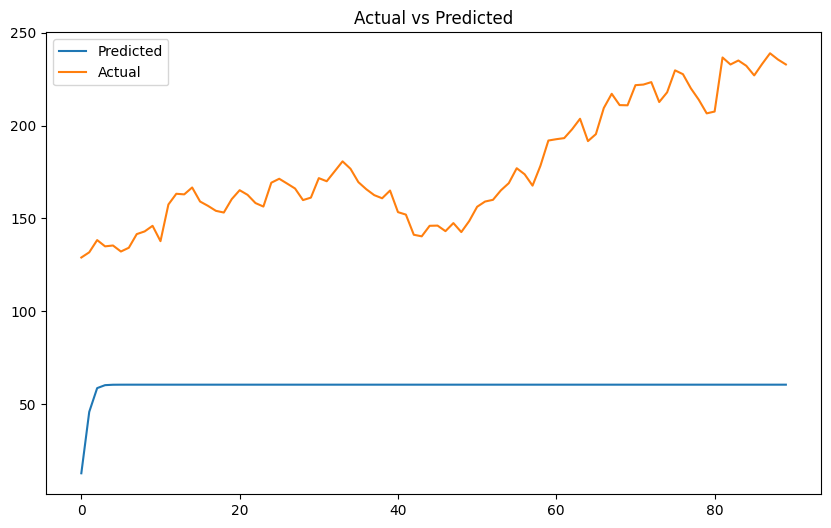

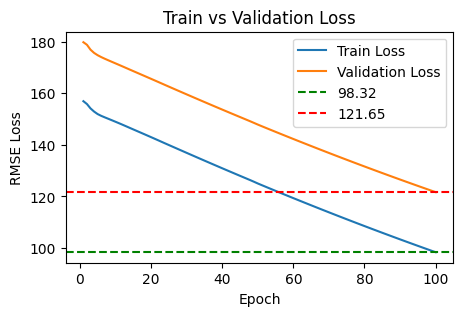

Length train, val: 170, 90.
Layer: lstm.weight_ih_l0 | Max Gradient: 0.339525043964386
Layer: lstm.weight_hh_l0 | Max Gradient: 0.0704169049859047
Layer: lstm.bias_ih_l0 | Max Gradient: 0.6917914152145386
Layer: lstm.bias_hh_l0 | Max Gradient: 0.6917914152145386
Layer: lstm.weight_ih_l1 | Max Gradient: 0.2485206425189972
Layer: lstm.weight_hh_l1 | Max Gradient: 0.35464879870414734
Layer: lstm.bias_ih_l1 | Max Gradient: 1.7613141536712646
Layer: lstm.bias_hh_l1 | Max Gradient: 1.7613141536712646
Layer: lstm.weight_ih_l2 | Max Gradient: 1.0681695938110352
Layer: lstm.weight_hh_l2 | Max Gradient: 1.139811396598816
Layer: lstm.bias_ih_l2 | Max Gradient: 6.138064384460449
Layer: lstm.bias_hh_l2 | Max Gradient: 6.138064384460449
Layer: lstm.weight_ih_l3 | Max Gradient: 4.396823406219482
Layer: lstm.weight_hh_l3 | Max Gradient: 5.068480968475342
Layer: lstm.bias_ih_l3 | Max Gradient: 24.637346267700195
Layer: lstm.bias_hh_l3 | Max Gradient: 24.637346267700195
Layer: fc.weight | Max Gradient: 

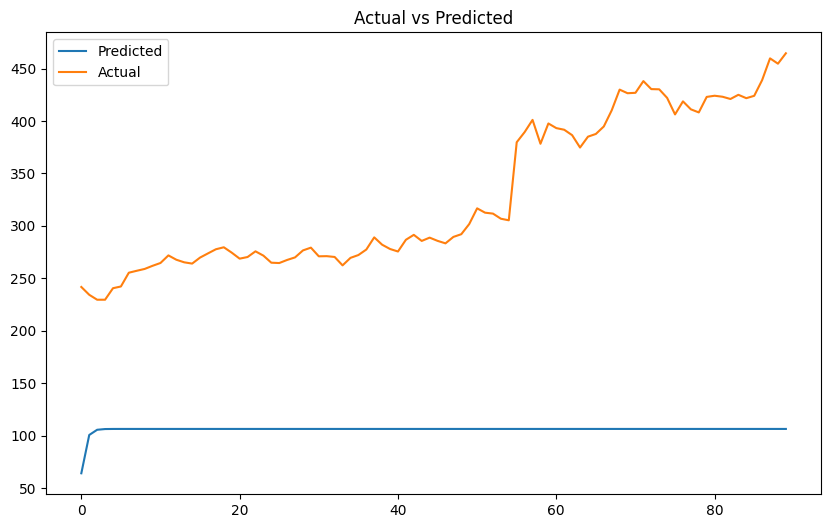

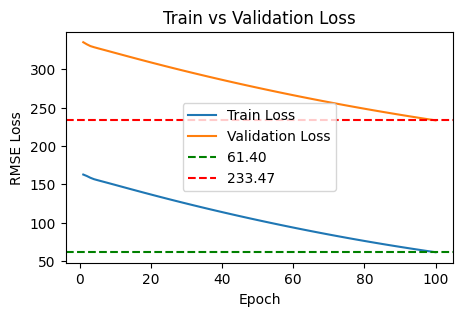

Length train, val: 260, 90.
Layer: lstm.weight_ih_l0 | Max Gradient: 0.6303488612174988
Layer: lstm.weight_hh_l0 | Max Gradient: 0.15532177686691284
Layer: lstm.bias_ih_l0 | Max Gradient: 0.6652559041976929
Layer: lstm.bias_hh_l0 | Max Gradient: 0.6652559041976929
Layer: lstm.weight_ih_l1 | Max Gradient: 0.5744724273681641
Layer: lstm.weight_hh_l1 | Max Gradient: 0.9634019732475281
Layer: lstm.bias_ih_l1 | Max Gradient: 2.4612162113189697
Layer: lstm.bias_hh_l1 | Max Gradient: 2.4612162113189697
Layer: lstm.weight_ih_l2 | Max Gradient: 3.0523741245269775
Layer: lstm.weight_hh_l2 | Max Gradient: 2.9803173542022705
Layer: lstm.bias_ih_l2 | Max Gradient: 7.597029685974121
Layer: lstm.bias_hh_l2 | Max Gradient: 7.597029685974121
Layer: lstm.weight_ih_l3 | Max Gradient: 9.770316123962402
Layer: lstm.weight_hh_l3 | Max Gradient: 8.493428230285645
Layer: lstm.bias_ih_l3 | Max Gradient: 25.169275283813477
Layer: lstm.bias_hh_l3 | Max Gradient: 25.169275283813477
Layer: fc.weight | Max Gradient

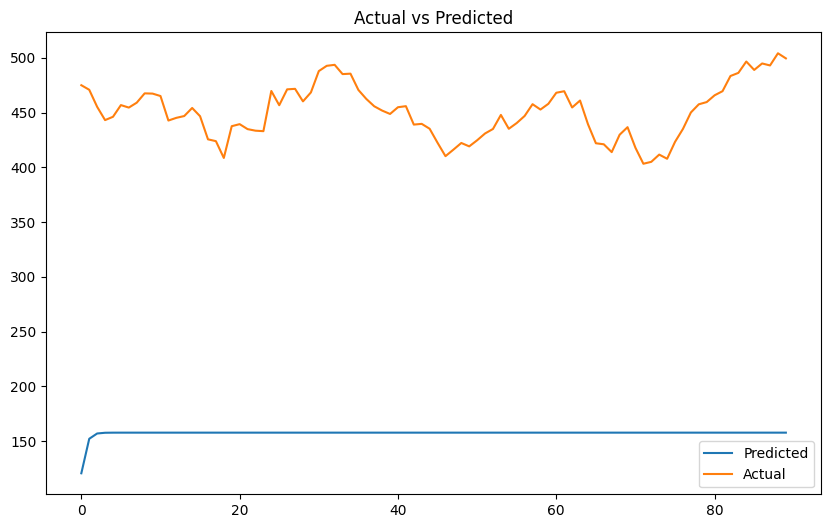

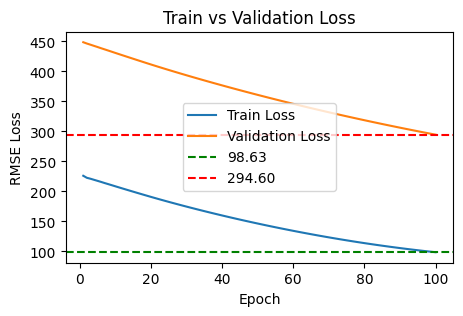

In [54]:
DEVICE = torch.device('mps')
device = torch.device('mps') # torch.device('cpu')
n_splits = 3
split_idx = int(len(df2) * 0.8)
scaler_type = 'minmax' # Standard scaler does not provide good results
batch_size = 128 # Larger batch size takes longer to converge, tried 64 and 32
shuffle = False

# FIXME: Assess the model on different sets and use the best one
# TODO: Gap
tscv = TimeSeriesSplit(n_splits=n_splits, gap=10)

# TODO: Assess the models
# Now do CV for assessing robustness, but later on, the train and validation should
# Choose the best model/just go according to the sequential split
print(f"Length train + val, test: {split_idx}, {len(df2) - split_idx}")
for train_idx, val_idx in tscv.split(X.iloc[:split_idx]):
    print(f"Length train, val: {len(train_idx)}, {len(val_idx)}.")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    X_train_scaled, X_val_scaled = scale(X_train=X_train, X_val=X_val, type=scaler_type)
    
    train_dataloader = load_data(X=X_train_scaled, y=y_train, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = load_data(X=X_val_scaled, y=y_val, batch_size=batch_size, shuffle=shuffle)

    kwargs = {
        'input_size': X.shape[-1],
        'hidden_size': 64 , # 64 and 128 have weird spikes at the end
        'num_layers': 4,
        'train_dataloader': train_dataloader,
        'val_dataloader': val_dataloader
        
    }
    # lr 0.1 is too high, will fluctuate at the end 
    # FIXME: Edit n_epoch
    model = custom_model(type='LSTM', lr=0.01, n_epoch=100, device=DEVICE, **kwargs) # It's wrong to write kwargs=kwargs
    model.fit()
    model.plot_loss()

    # model = custom_model(type='LSTM', lr=0.05, n_epoch=100, device=device, **kwargs) # It's wrong to write kwargs=kwargs
    # model.fit()
    # model.plot_loss()

# Use the last model with all the training and validation data
test_model = model
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]



## Prediction
- Add SHAP values

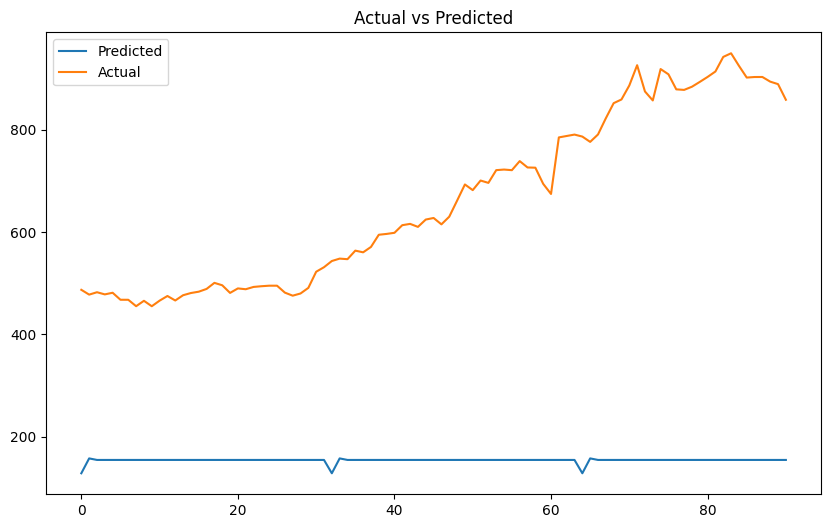

In [47]:
# Parameters are similar to that in training
_, X_test_scaled = scale(X_train=X_train, X_val=X_test, type=scaler_type)
test_dataloader = load_data(X=X_test, y=y_test, batch_size=batch_size, shuffle=shuffle)
pred_dict, avg_test_loss = test_model.evaluate(test_dataloader=test_dataloader)


RMSE: 535.35233, average test loss: 535.35233 should be similar


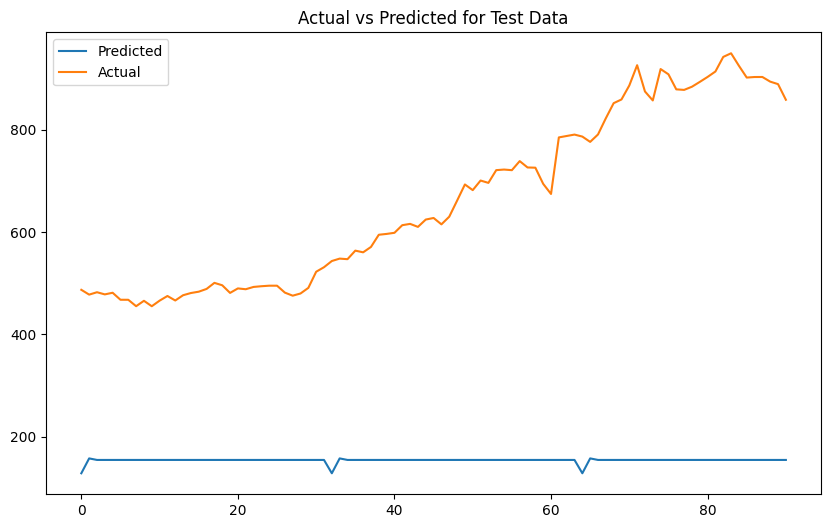

In [48]:
pred_df = pd.DataFrame(pred_dict)
pred_list = pred_dict['predicted']
actual_list = pred_dict['actual']

from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_true=actual_list, y_pred=pred_list)
print(f"RMSE: {rmse:.5f}, average test loss: {avg_test_loss:.5f} should be similar") 


plt.figure(figsize=(10, 6))
x = range(len(pred_list))

plt.plot(x, pred_list, label='Predicted')
plt.plot(x, actual_list, label='Actual')
plt.title('Actual vs Predicted for Test Data')
plt.legend()
plt.show()

In [72]:
test_model.model.eval()
X_train_tensor = torch.tensor(X_train_scaled[:1000], dtype=torch.float32).to(DEVICE) # FIXME: Edit size
X_test_tensor = torch.tensor(X_test_scaled[:5], dtype=torch.float32).to(DEVICE)
# Need to use DeepExplainer for PyTorch, instead of Explainer
# Analyse how each feature contributes to the prediction
deepExplainer = shap.DeepExplainer(model=test_model.model, data=X_train_tensor)
# Approximate shap values for the prediction
shap_values = deepExplainer.shap_values(X_test_tensor)

/Users/tangyiqwan/dev/projects/quant/cz4042/venv/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: RNN
  warnings.warn(f'unrecognized nn.Module: {module_type}')


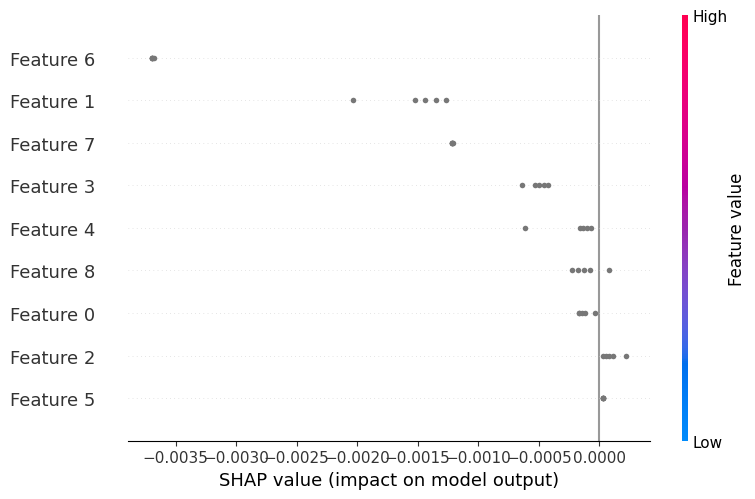

In [77]:
shap_values_squeezed = np.squeeze(shap_values, axis=2)
shap_values_squeezed.shape
shap.summary_plot(shap_values_squeezed, X_test_tensor)

In [65]:
X_test_numpy = X_test_tensor.cpu().numpy()
X_test_numpy.shape

(5, 9)

In [68]:
shap.initjs()
# deepExplainer.expected_value = deepExplainer.expected_value[0]
shap.plots.force(deepExplainer.expected_value, shap_values_squeezed, X_test_numpy, matplotlib=False)

Afterwards for really testing against test

In [ ]:
#
# X_train, X_val, y_train, y_val = train_test_split(X.iloc[:split_idx], y.iloc[:split_idx], shuffle=False, test_size=0.2)